In [19]:
from datetime import date, datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [80]:
from sklearn.model_selection import train_test_split
from sklearn import tree
import random, numpy
from numpy.random import seed

SEED = 12345678

**Simple Moving Average**

In [21]:
def SMA(data,n):
    
    #додаємо NaN на початку
	sma_list=[np.nan for k in range(n-1)]
    
	for i in range(len(data)-n+1):
		sum_n = 0
		for j in range(n):
			sum_n = sum_n + data[i+j]
		sma=sum_n/n
		sma_list.append(round(sma, 2))
        
	return sma_list

**Linear Weighted Moving Average**

In [22]:
def LWMA(data,n):
    
	lma_list=[np.nan for k in range(n-1)]

	for i in range(len(data)-n+1):
		sum_n, sum_j = 0, 0
		for j in range(n):
			sum_n = sum_n + (j+1)*data[i+j]
			sum_j = sum_j + (j+1)
		lma=sum_n/sum_j
		lma_list.append(lma)

	return lma_list

In [23]:
def EMA(data, n, a=0):
	ema_list=[data[0]]
	if a==0:
		a=2/(n+1)

	for i in range (1,len(data)):
		ema = 0
		ema = (1-a)*ema_list[i-1]+a*data[i]
		ema_list.append(ema)

	return ema_list

**SO**

In [24]:
def SO(data_close, data_high, data_low, n):
	K, D = [np.nan for k in range(n-1)], [np.nan for k in range(n-1)]
	highest_high, lowest_low = [np.nan for k in range(n-1)], [np.nan for k in range(n-1)]

	for i in range(len(data_close)-n+1):
		list_n_high, list_n_low = [], []
		for j in range(0, n):
			list_n_high.append(data_high[i+j])
			list_n_low.append(data_low[i+j])
		highest_high.append(max(list_n_high))
		lowest_low.append(min(list_n_low))

	for i in range(n-1, len(highest_high)):
		K.append(100*(data_close[i]-lowest_low[i])/(highest_high[i]-lowest_low[i]))
	D = SMA(K, n)

	return K, D

**CCI**

In [25]:
def CCI(data_close, data_high, data_low, n):
	p_typical = []

	for i in range(len(data_close)):
		p_typical.append((data_close[i]+data_low[i]+data_high[i])/3)
	sma = SMA(p_typical,n)

	MAD = [np.nan for k in range(n-1)]
	for j in range(n-1, len(data_close)):
		mad = 0
		for s in range(n):
			mad = mad +  abs(p_typical[j-s]-sma[j])
		MAD.append(mad/n)

	CCI = [np.nan for n in range(n-1)]
	for t in range(n-1, len(data_close)):
		cci = (p_typical[t]-sma[t])/(0.015*MAD[t])
		CCI.append(cci)

	return CCI

**Disparsity Index**

In [26]:
def DI(data, n, MA_type):
    if MA_type == "EMA":
        MA = EMA(data, n)
    elif MA_type == "LWMA":
        MA = LWMA(data, n)
    else:
        MA = SMA(data, n)
    
    di_list = []
    for i in range(len(MA)):
        if (np.isnan(MA[i])):
            di_list.append(np.nan)
        else:
            di_list.append((data[i]-MA[i])/(100*MA[i]))
        
    return di_list

**Elder-Ray Index**

In [27]:
def ERI(data_close, data_high, data_low, n):
    MA = EMA(data_close, n)
    
    BuP, BeP = [], []
    for i in range(len(data_close)):
        BuP.append(data_high[i] - MA[i])
        BeP.append(data_low[i] - MA[i])
    return BuP, BeP

**Strategy with moving averages**

Сигнали - перетин ціни і плинного середнього

P - list of Close prices

n1 - к-ть періодів для середнього

MA_type - тип середнього ("SMA", "EMA", "LWMA")

In [28]:
def strategy_MA_1(P, n1, MA_type, n2=26, n3=9):
	MA= []
	if MA_type == "SMA":
		MA = SMA(P, n1)
	elif MA_type == "EMA":
		MA = EMA(P, n1)
	elif MA_type == "LWMA":
		MA = LWMA(P, n1)

	if MA_type != "EMA":
		s=[np.nan for k in range(n1)]
		for i in range(n1, len(MA)):
			if (P[i-1]<MA[i-1]) and (P[i]>MA[i]):
				s.append(1)
			elif (P[i-1]>MA[i-1]) and (P[i]<MA[i]):
				s.append(-1)
			else:
				s.append(0)
	elif MA_type == "EMA":
		s=[np.nan]
		for i in range(1,len(MA)):
			if (P[i-1]<MA[i-1]) and (P[i]>MA[i]):
				s.append(1)
			elif (P[i-1]>MA[i-1]) and (P[i]<MA[i]):
				s.append(-1)
			else:
				s.append(0)
	return s

**Strategy SO**

In [29]:
def strategy_SO(P_close, P_high, P_low, n):
	K, D = SO(P_close, P_high, P_low, n)
	s=[np.nan for k in range(n)]
	for i in range(n, len(P_close)):
		if (K[i]>D[i]) and (K[i-1]<D[i-1]):
			s.append(-1)
		elif (K[i]<D[i]) and (K[i-1]>D[i-1]):
			s.append(1)
		else:
			s.append(0)
	return s

**Strategy CCI**

In [30]:
def strategy_CCI(data_close, data_high, data_low, n):
	cci = CCI(data_close, data_high, data_low, n)
	s=[]
	for i in range(len(data_close)):
		if ((cci[i]>0) and (cci[i-1]<0)):
			s.append(1)
		elif ((cci[i]<0) and (cci[i-1]>0)):
			s.append(-1)
		else:
			s.append(0)
	return s

**Strategy DI**

In [31]:
def strategy_DI(P_close, n):
    DI_ = DI(P_close, n, MA_type="SMA")
    
    s=[np.nan]
    for i in range(1,len(DI_)):
        if np.isnan(DI_[i]):
            s.append(np.nan)
        elif ((DI_[i]>0)&(DI_[i-1]<0)):
            s.append(1)
        elif ((DI_[i]<0)&(DI_[i-1]>0)):
            s.append(-1)
        else:
            s.append(0)
            
    return s

**Strategy ERI**

In [32]:
def strategy_ERI(P_close, P_high, P_low, n=13):
    BuP_ = ERI(P_close, P_high, P_low, n)[0]
    BeP_ = ERI(P_close, P_high, P_low, n)[1]
    
    s=[np.nan]
    for i in range(1, len(BuP_)):
        if ((BeP_[i]>0)&(BeP_[i-1]<0)):
            s.append(1)
        elif ((BuP_[i]<0)&(BuP_[i-1]>0)):

            s.append(-1)
        else:
            s.append(0)
            
    return s

**Strategy MAE**

In [33]:
def strategy_MAE(P, upper, lower, n1, MA_type, MAE_type="LL"):
	if n1 >= 0:
		UL, LL, MA = [], [], []
		if MA_type == "SMA":
			MA = SMA(P, n1)
		elif MA_type == "EMA":
			MA = EMA(P, n1)
		elif MA_type == "LWMA":
			MA = LWMA(P, n1)

		for i in range(len(P)):
			UL.append((1+upper)*MA[i])
			LL.append((1-lower)*MA[i])
		if MA_type != "EMA":
			s=[np.nan for k in range(n1)]
			if MAE_type == "UL":
				for i in range(n1, len(MA)):
					if (P[i-1]<UL[i-1]) and (P[i]>UL[i]):
						s.append(1)
					elif (P[i-1]>UL[i-1]) and (P[i]<UL[i]):
						s.append(-1)
					else:
						s.append(0)
			elif MAE_type == "LL":
				for i in range(n1, len(MA)):
					if (P[i-1]<LL[i-1]) and (P[i]>LL[i]):
						s.append(1)
					elif (P[i-1]>LL[i-1]) and (P[i]<LL[i]):
						s.append(-1)
					else:
						s.append(0)
		elif MA_type == "EMA":
			s=[np.nan]
			if MAE_type == "UL":
				for i in range(1, len(MA)):
					if (P[i-1]<UL[i-1]) and (P[i]>UL[i]):
						s.append(1)
					elif (P[i-1]>UL[i-1]) and (P[i]<UL[i]):
						s.append(-1)
					else:
						s.append(0)
			elif MAE_type == "LL":
				for i in range(1, len(MA)):
					if (P[i-1]<LL[i-1]) and (P[i]>LL[i]):
						s.append(1)
					elif (P[i-1]>LL[i-1]) and (P[i]<LL[i]):
						s.append(-1)
					else:
						s.append(0)
		return s
	else:
		return ["nan", "nan"]

In [34]:
def signal_convertation(signals):
    non_zero_element = 0
    converted_signals = []
    #елементи на початку ряду можуть бути нулями, ми їх не змінюємо до появи першого сигналу
    
    for i in range(len(signals)):
        if np.isnan(signals[i]):
            converted_signals.append(np.nan)
        else:
            if signals[i] != 0:
                non_zero_element = signals[i]
                converted_signals.append(signals[i])
            else:
                converted_signals.append(non_zero_element)
                
    return converted_signals

In [35]:
def trading_results(price, signal):
    results=["n/a" for i in range(len(price))]
    open_short, close_short, open_long, close_long = 0, 0, 0, 0
    
    
    for i in range(1,len(signal)):
        
        if signal[i] == 0 and signal[i-1] == 1:
            open_short = i
            close_long = i
            #рахуємо прибутковість довгої позиції
            #result = (price[close_long] - price[open_long])/price[open_long]
            result = (price[close_long] - price[open_long])/price[open_long] - 0.4/100
            results[i] = result
            
        if signal[i] == 1 and signal[i-1] == 0:
            close_short = i
            open_long = i
            #рахуємо прибутковість короткої позиції
            #result = -(price[close_short] - price[open_short])/price[open_short]
            result = -(price[close_short] - price[open_short])/price[open_short] - 0.4/100
            results[i] = result
            
    return(results)

In [36]:
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_excel('UX-dailyhistory.xlsx', header = None, skiprows = 1, names = columns)

In [37]:
df.index = df["Date"]
df.index = pd.to_datetime(df.index)
df.drop(['Date', 'Volume'], axis='columns', inplace=True)
df = df.sort_index()
df.head()

,Open,High,Low,Close
Date,,,,
2009-03-26,500.00,500.00,500.00,500.00
2009-03-27,557.04,567.24,508.31,509.86
2009-03-30,509.35,509.87,502.22,509.87
2009-03-31,509.70,511.46,509.70,511.46
2009-04-01,508.05,521.66,508.05,521.66


In [38]:
import pandas as pd
import missingno as msno

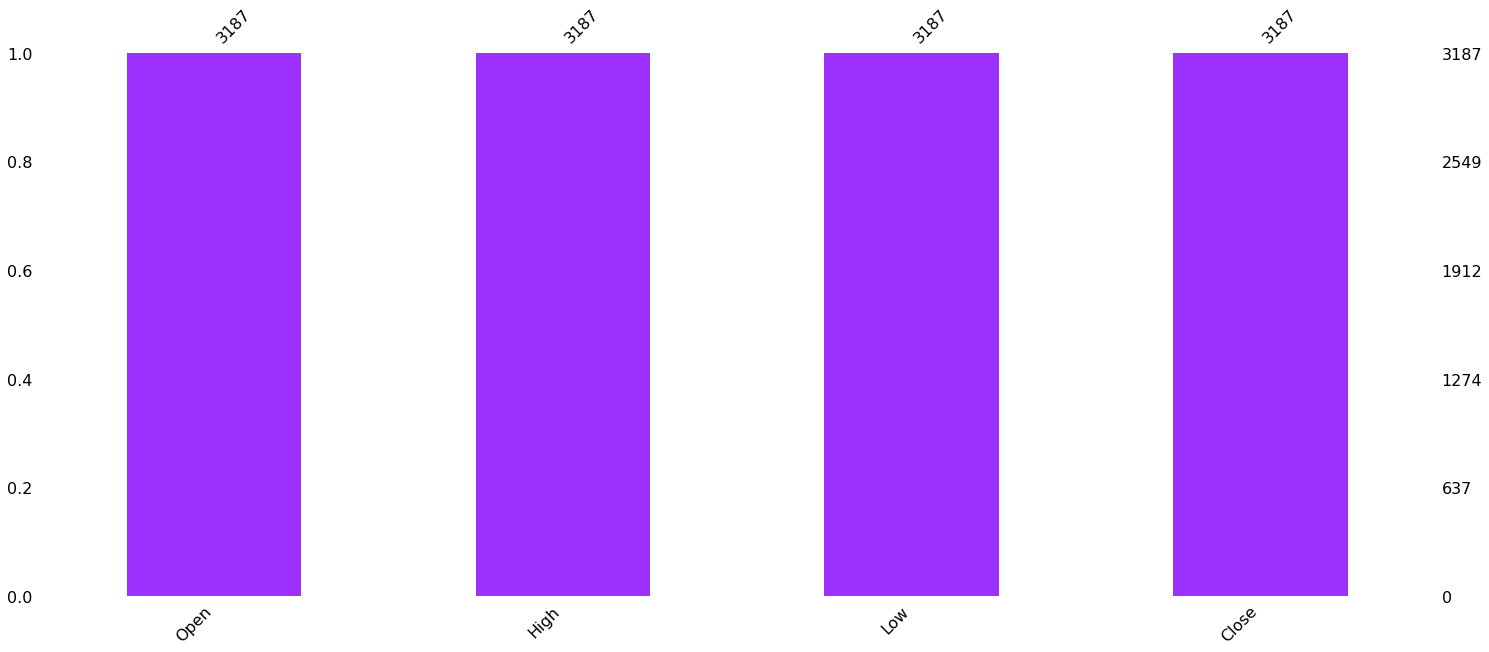

In [39]:
msno.bar(df, color = (138/225,43/225,225/225))

In [40]:
df

,Open,High,Low,Close
Date,,,,
2009-03-26,500.00,500.00,500.00,500.00
2009-03-27,557.04,567.24,508.31,509.86
2009-03-30,509.35,509.87,502.22,509.87
2009-03-31,509.70,511.46,509.70,511.46
2009-04-01,508.05,521.66,508.05,521.66
...,...,...,...,...
2022-02-18,1785.48,1796.03,1765.74,1774.84
2022-02-21,1774.84,1803.77,1766.02,1766.02
2022-02-22,1766.02,1787.89,1718.72,1759.73


In [41]:
#якщо ціна наступного дня зросла - ставимо 1
to_predict = []
for i in range(0,len(df.Close)-1):
    if df.Close[i+1] > df.Close[i]:
        to_predict.append(1)
    else:
        to_predict.append(0)

to_predict.append(np.nan)

In [42]:
df["DI"] = signal_convertation(strategy_DI(P_close=df.Close, n=12))
df["ERI"] = signal_convertation(strategy_ERI(P_close=df.Close, P_high=df.High, P_low=df.Low, n=13))
df["SMA_1"] = signal_convertation(strategy_MA_1(P = df.Close, n1 = 12, MA_type = "SMA"))
df["EMA_1"] = signal_convertation(strategy_MA_1(P = df.Close, n1 = 7, MA_type = "EMA"))
df["LWMA_1"] = signal_convertation(strategy_MA_1(P = df.Close, n1 = 15, MA_type = "LWMA"))
df["MAE_1"] = signal_convertation(strategy_MAE(P=df.Close, upper=0, lower=0.01, n1=34, MA_type="SMA", MAE_type="LL"))
df["MAE_2"] = signal_convertation(strategy_MAE(P=df.Close, upper=0, lower=0.01, n1=6, MA_type="EMA", MAE_type="LL"))
df["MAE_3"] = signal_convertation(strategy_MAE(P=df.Close, upper=0, lower=0.01, n1=17, MA_type="LWMA", MAE_type="LL"))
df["MAE_4"] = signal_convertation(strategy_MAE(P=df.Close, upper=0.015, lower=0, n1=21, MA_type="SMA", MAE_type="UL"))
df["MAE_5"] = signal_convertation(strategy_MAE(P=df.Close, upper=0.01, lower=0, n1=13, MA_type="EMA", MAE_type="UL"))
df["MAE_6"] = signal_convertation(strategy_MAE(P=df.Close, upper=0.01, lower=0, n1=22, MA_type="LWMA", MAE_type="UL"))
#df["SO_1"] = strategy_SO(P_close=df.Close, P_high=df.High, P_low=df.Low, n=47)

In [43]:
df

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,MAE_2,MAE_3,MAE_4,MAE_5,MAE_6
Date,,,,,,,,,,,,,,,
2009-03-26,500.00,500.00,500.00,500.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-27,557.04,567.24,508.31,509.86,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN
2009-03-30,509.35,509.87,502.22,509.87,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN
2009-03-31,509.70,511.46,509.70,511.46,NaN,1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN
2009-04-01,508.05,521.66,508.05,521.66,NaN,1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,1785.48,1796.03,1765.74,1774.84,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-21,1774.84,1803.77,1766.02,1766.02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-22,1766.02,1787.89,1718.72,1759.73,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [44]:
#прибираэмо нулы на початку при розрахунку методів ТА - для кожного методу окремо (один раз)
df = df.replace(0, np.nan)

In [45]:
df["Percent change 1"] = 100*df["Close"].pct_change(periods=1)
df["Percent change 5"] = 100*df["Close"].pct_change(periods=5)
df["Percent change 30"] = 100*df["Close"].pct_change(periods=30)
df["Percent change Open"] = 100*df["Open"].pct_change(periods=1)
df["Percent change High"] = 100*df["High"].pct_change(periods=1)
df["Percent change Low"] = 100*df["Low"].pct_change(periods=1)

In [46]:
df["Y"] = to_predict
df.tail()

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low,Y
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-18,1785.48,1796.03,1765.74,1774.84,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,-0.595918,3.565906,2.278569,3.967159,0.590878,3.149864,0.0
2022-02-21,1774.84,1803.77,1766.02,1766.02,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,-0.496946,4.124854,1.770299,-0.595918,0.430950,0.015857,0.0
2022-02-22,1766.02,1787.89,1718.72,1759.73,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,-0.356168,2.926244,0.735597,-0.496946,-0.880378,-2.678339,0.0
2022-02-23,1759.73,1792.64,1718.50,1718.50,-1.0,1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-2.342973,0.066964,-0.354283,-0.356168,0.265676,-0.012800,0.0
2022-02-25,1718.50,1718.50,1718.50,1718.50,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,0.000000,-3.751372,-2.764025,-2.342973,-4.135800,0.000000,NaN


In [47]:
df.head()

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low,Y
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-26,500.00,500.00,500.00,500.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2009-03-27,557.04,567.24,508.31,509.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.972000,NaN,NaN,11.408000,13.448000,1.662000,1.0
2009-03-30,509.35,509.87,502.22,509.87,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.001961,NaN,NaN,-8.561324,-10.113885,-1.198088,1.0
2009-03-31,509.70,511.46,509.70,511.46,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.311844,NaN,NaN,0.068715,0.311844,1.489387,1.0
2009-04-01,508.05,521.66,508.05,521.66,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.994291,NaN,NaN,-0.323720,1.994291,-0.323720,1.0


In [48]:
X = df.copy()
X_train, X_valid = train_test_split(X, train_size=0.8, random_state=42, shuffle=False)

In [49]:
X_train

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low,Y
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-26,500.00,500.00,500.00,500.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2009-03-27,557.04,567.24,508.31,509.86,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.972000,NaN,NaN,11.408000,13.448000,1.662000,1.0
2009-03-30,509.35,509.87,502.22,509.87,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.001961,NaN,NaN,-8.561324,-10.113885,-1.198088,1.0
2009-03-31,509.70,511.46,509.70,511.46,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.311844,NaN,NaN,0.068715,0.311844,1.489387,1.0
2009-04-01,508.05,521.66,508.05,521.66,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.994291,NaN,NaN,-0.323720,1.994291,-0.323720,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-22,1593.63,1593.63,1587.99,1587.99,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-0.353909,-0.402657,-8.052413,-0.048921,-0.244751,0.783808,1.0
2019-07-23,1587.99,1604.56,1587.99,1597.37,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,0.590684,0.185649,-6.610580,-0.353909,0.685856,0.000000,0.0
2019-07-24,1597.37,1598.31,1587.52,1587.52,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-0.616639,-0.383401,-5.737053,0.590684,-0.389515,-0.029597,0.0


In [50]:
X_valid

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low,Y
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-29,1587.52,1614.96,1587.52,1614.96,1.0,-1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,1.0,1.728482,1.698373,-1.954880,0.000000,1.728482,0.000000,0.0
2019-07-30,1614.96,1614.96,1603.24,1603.24,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-0.725715,0.367479,-2.666408,1.728482,0.000000,0.990224,0.0
2019-07-31,1603.24,1610.91,1601.91,1601.91,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-0.082957,0.906445,-2.515746,-0.725715,-0.250780,-0.082957,0.0
2019-08-01,1601.91,1601.91,1601.91,1601.91,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,0.000000,0.906445,-0.488269,-0.082957,-0.558690,0.000000,0.0
2019-08-02,1601.91,1601.91,1583.93,1583.93,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.122410,-0.226139,-1.605198,0.000000,0.000000,-1.122410,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,1785.48,1796.03,1765.74,1774.84,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,-0.595918,3.565906,2.278569,3.967159,0.590878,3.149864,0.0
2022-02-21,1774.84,1803.77,1766.02,1766.02,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,-0.496946,4.124854,1.770299,-0.595918,0.430950,0.015857,0.0
2022-02-22,1766.02,1787.89,1718.72,1759.73,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,-0.356168,2.926244,0.735597,-0.496946,-0.880378,-2.678339,0.0


In [51]:
X_train = X_train.dropna()
X_valid = X_valid.dropna()
y_train = X_train.pop('Y')
y_valid = X_valid.pop('Y')

In [52]:
X_train

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_3,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-17,1059.69,1059.69,1024.47,1025.18,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-3.064515,-8.154453,28.439700,2.044373,-0.927441,0.669182
2009-06-18,1026.92,1031.08,994.05,1008.52,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.625080,-9.233926,18.782168,-3.092414,-2.699846,-2.969340
2009-06-19,1009.33,1030.27,1009.33,1025.47,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,1.680681,-7.501150,15.480856,-1.712889,-0.078558,1.537146
2009-06-22,1025.47,1025.47,977.64,977.64,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-4.664203,-5.964507,1.730471,1.599081,-0.465897,-3.139707
2009-06-23,975.62,975.62,938.97,956.65,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-2.147007,-9.544341,-4.961305,-4.861186,-4.861186,-3.955444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-22,1593.63,1593.63,1587.99,1587.99,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-0.353909,-0.402657,-8.052413,-0.048921,-0.244751,0.783808
2019-07-23,1587.99,1604.56,1587.99,1597.37,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,0.590684,0.185649,-6.610580,-0.353909,0.685856,0.000000
2019-07-24,1597.37,1598.31,1587.52,1587.52,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-0.616639,-0.383401,-5.737053,0.590684,-0.389515,-0.029597


In [53]:
X_valid

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_3,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-29,1587.52,1614.96,1587.52,1614.96,1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,1.0,1.728482,1.698373,-1.954880,0.000000,1.728482,0.000000
2019-07-30,1614.96,1614.96,1603.24,1603.24,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-0.725715,0.367479,-2.666408,1.728482,0.000000,0.990224
2019-07-31,1603.24,1610.91,1601.91,1601.91,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,-0.082957,0.906445,-2.515746,-0.725715,-0.250780,-0.082957
2019-08-01,1601.91,1601.91,1601.91,1601.91,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,-1.0,-1.0,0.000000,0.906445,-0.488269,-0.082957,-0.558690,0.000000
2019-08-02,1601.91,1601.91,1583.93,1583.93,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.122410,-0.226139,-1.605198,0.000000,0.000000,-1.122410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,1717.35,1785.48,1711.82,1785.48,1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,3.967159,5.402725,3.710502,0.447447,3.614807,1.761394
2022-02-18,1785.48,1796.03,1765.74,1774.84,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-0.595918,3.565906,2.278569,3.967159,0.590878,3.149864
2022-02-21,1774.84,1803.77,1766.02,1766.02,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-0.496946,4.124854,1.770299,-0.595918,0.430950,0.015857


In [54]:
y_train

Date
2009-06-17    0.0
2009-06-18    1.0
2009-06-19    0.0
2009-06-22    0.0
2009-06-23    1.0
             ... 
2019-07-22    1.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    1.0
Name: Y, Length: 2495, dtype: float64

In [55]:
y_valid

Date
2019-07-29    0.0
2019-07-30    0.0
2019-07-31    0.0
2019-08-01    0.0
2019-08-02    1.0
             ... 
2022-02-17    0.0
2022-02-18    0.0
2022-02-21    0.0
2022-02-22    0.0
2022-02-23    0.0
Name: Y, Length: 637, dtype: float64

In [56]:
class Normalizer:
    def fit(self, X: np.array) -> None:
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0)
        
    def transform(self, X: np.array) -> np.array:
        return (X - self.mu[np.newaxis, :]) / self.sigma[np.newaxis, :]

In [57]:
normalizer = Normalizer()
normalizer.fit(X_train)
X_train_transformed = normalizer.transform(X_train)
X_test_transformed = normalizer.transform(X_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


In [58]:
X_train_transformed

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_3,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-17,-0.497473,-0.518744,-0.542088,-0.564172,-1.072567,-1.086495,-1.072567,-1.079505,-1.056292,-1.304783,...,-1.548619,-0.765445,-0.747113,-0.786658,-1.717798,-1.908294,2.346694,1.118445,-0.568257,0.341857
2009-06-18,-0.560485,-0.573347,-0.601106,-0.596222,-1.072567,-1.086495,-1.072567,-1.079505,-1.056292,-1.304783,...,-1.548619,-0.765445,-0.747113,-0.786658,-0.919394,-2.155682,1.515164,-1.738106,-1.620261,-1.619822
2009-06-19,-0.594308,-0.574893,-0.571461,-0.563614,-1.072567,-1.086495,-1.072567,-1.079505,-1.056292,-1.304783,...,-1.548619,-0.765445,-0.747113,-0.786658,0.914198,-1.758574,1.230916,-0.970957,-0.064406,0.809813
2009-06-22,-0.563273,-0.584054,-0.632943,-0.655628,-1.072567,-1.086495,-1.072567,-1.079505,-1.056292,-1.304783,...,-1.548619,-0.765445,-0.747113,-0.786658,-2.605090,-1.406414,0.046985,0.870819,-0.294309,-1.711673
2009-06-23,-0.659128,-0.679194,-0.707967,-0.696008,-1.072567,-1.086495,-1.072567,-1.079505,-1.056292,-1.304783,...,-1.548619,-0.765445,-0.747113,-0.786658,-1.208888,-2.226821,-0.529187,-2.721715,-2.903115,-2.151471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-22,0.529216,0.500291,0.551198,0.518546,-1.072567,-1.086495,-1.072567,-1.079505,-1.056292,-1.304783,...,0.645478,-0.765445,-0.747113,-0.786658,-0.214319,-0.131778,-0.795337,-0.045629,-0.163049,0.403657
2019-07-23,0.518371,0.521151,0.551198,0.536591,-1.072567,-1.086495,-1.072567,0.925979,-1.056292,-1.304783,...,0.645478,-0.765445,-0.747113,-0.786658,0.309614,0.003046,-0.671193,-0.215232,0.389309,-0.018927
2019-07-24,0.536408,0.509223,0.550286,0.517642,-1.072567,-1.086495,-1.072567,-1.079505,-1.056292,-1.304783,...,0.645478,-0.765445,-0.747113,-0.786658,-0.360046,-0.127365,-0.595981,0.310053,-0.248973,-0.034884


In [59]:
X_test_transformed

,Open,High,Low,Close,DI,ERI,SMA_1,EMA_1,LWMA_1,MAE_1,...,MAE_3,MAE_4,MAE_5,MAE_6,Percent change 1,Percent change 5,Percent change 30,Percent change Open,Percent change High,Percent change Low
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-29,0.517468,0.541000,0.550286,0.570430,0.931969,-1.086495,0.931969,0.925979,0.946328,0.766104,...,0.645478,-0.765445,-0.747113,1.270691,0.940712,0.349725,-0.270329,-0.018425,1.008155,-0.018927
2019-07-30,0.570231,0.541000,0.580785,0.547884,0.931969,0.920022,0.931969,0.925979,0.946328,0.766104,...,0.645478,-0.765445,-0.747113,-0.786658,-0.420546,0.044717,-0.331593,0.942779,-0.017778,0.514944
2019-07-31,0.547695,0.533270,0.578204,0.545325,0.931969,0.920022,0.931969,0.925979,0.946328,0.766104,...,0.645478,-0.765445,-0.747113,-0.786658,-0.064031,0.168235,-0.318621,-0.421992,-0.166628,-0.063652
2019-08-01,0.545138,0.516094,0.578204,0.545325,0.931969,0.920022,0.931969,0.925979,0.946328,0.766104,...,0.645478,-0.765445,-0.747113,-0.786658,-0.018018,0.168235,-0.144052,-0.064557,-0.349386,-0.018927
2019-08-02,0.545138,0.516094,0.543321,0.510736,-1.072567,0.920022,-1.072567,-1.079505,-1.056292,-1.304783,...,0.645478,-0.765445,-0.747113,-0.786658,-0.640580,-0.091325,-0.240221,-0.018425,-0.017778,-0.624065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-17,0.767112,0.866441,0.791441,0.898472,0.931969,-1.086495,0.931969,0.925979,0.946328,0.766104,...,0.645478,1.305906,1.337950,1.270691,2.182428,1.198669,0.217469,0.230399,2.127776,0.930714
2022-02-18,0.898116,0.886576,0.896051,0.878003,0.931969,0.920022,0.931969,0.925979,0.946328,0.766104,...,0.645478,1.305906,1.337950,1.270691,-0.348553,0.777716,0.094177,2.187700,0.332935,1.679296
2022-02-21,0.877657,0.901347,0.896594,0.861035,0.931969,0.920022,0.931969,0.925979,0.946328,0.766104,...,0.645478,1.305906,1.337950,1.270691,-0.293657,0.905813,0.050415,-0.349813,0.238011,-0.010377


# **DT**

In [203]:
clf = tree.DecisionTreeClassifier(max_depth=15, min_samples_leaf=35, criterion = 'entropy', random_state=SEED) # defining decision tree classifier
clf=clf.fit(X_train_transformed,y_train) # train data on new data and new target

y_predicted_train = clf.predict(X_train_transformed)

y_predicted_test = clf.predict(X_test_transformed)

In [204]:
len(y_predicted_train)

2495

In [205]:
len(y_predicted_test)

637

In [206]:
acc_train = np.mean(y_predicted_train==y_train)
print(acc_train)

0.6400801603206413


In [207]:
acc_test = np.mean(y_predicted_test==y_valid)
print(acc_test)

0.4976452119309262


[Text(0.6458333333333334, 0.95, 'X[13] <= 0.295\nentropy = 1.0\nsamples = 2495\nvalue = [1267, 1228]'),
 Text(0.4140625, 0.85, 'X[3] <= 0.621\nentropy = 0.995\nsamples = 1601\nvalue = [864, 737]'),
 Text(0.234375, 0.75, 'X[15] <= -0.081\nentropy = 1.0\nsamples = 1216\nvalue = [620, 596]'),
 Text(0.09375, 0.65, 'X[20] <= -1.526\nentropy = 0.992\nsamples = 654\nvalue = [361, 293]'),
 Text(0.041666666666666664, 0.55, 'X[17] <= -0.672\nentropy = 0.951\nsamples = 81\nvalue = [30, 51]'),
 Text(0.020833333333333332, 0.45, 'entropy = 1.0\nsamples = 46\nvalue = [23, 23]'),
 Text(0.0625, 0.45, 'entropy = 0.722\nsamples = 35\nvalue = [7, 28]'),
 Text(0.14583333333333334, 0.55, 'X[18] <= -0.042\nentropy = 0.983\nsamples = 573\nvalue = [331, 242]'),
 Text(0.10416666666666667, 0.45, 'X[1] <= 0.266\nentropy = 0.996\nsamples = 336\nvalue = [180, 156]'),
 Text(0.08333333333333333, 0.35, 'entropy = 0.989\nsamples = 290\nvalue = [163, 127]'),
 Text(0.125, 0.35, 'entropy = 0.95\nsamples = 46\nvalue = [17,

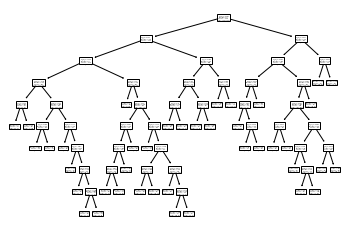

In [208]:
tree.plot_tree(clf) 

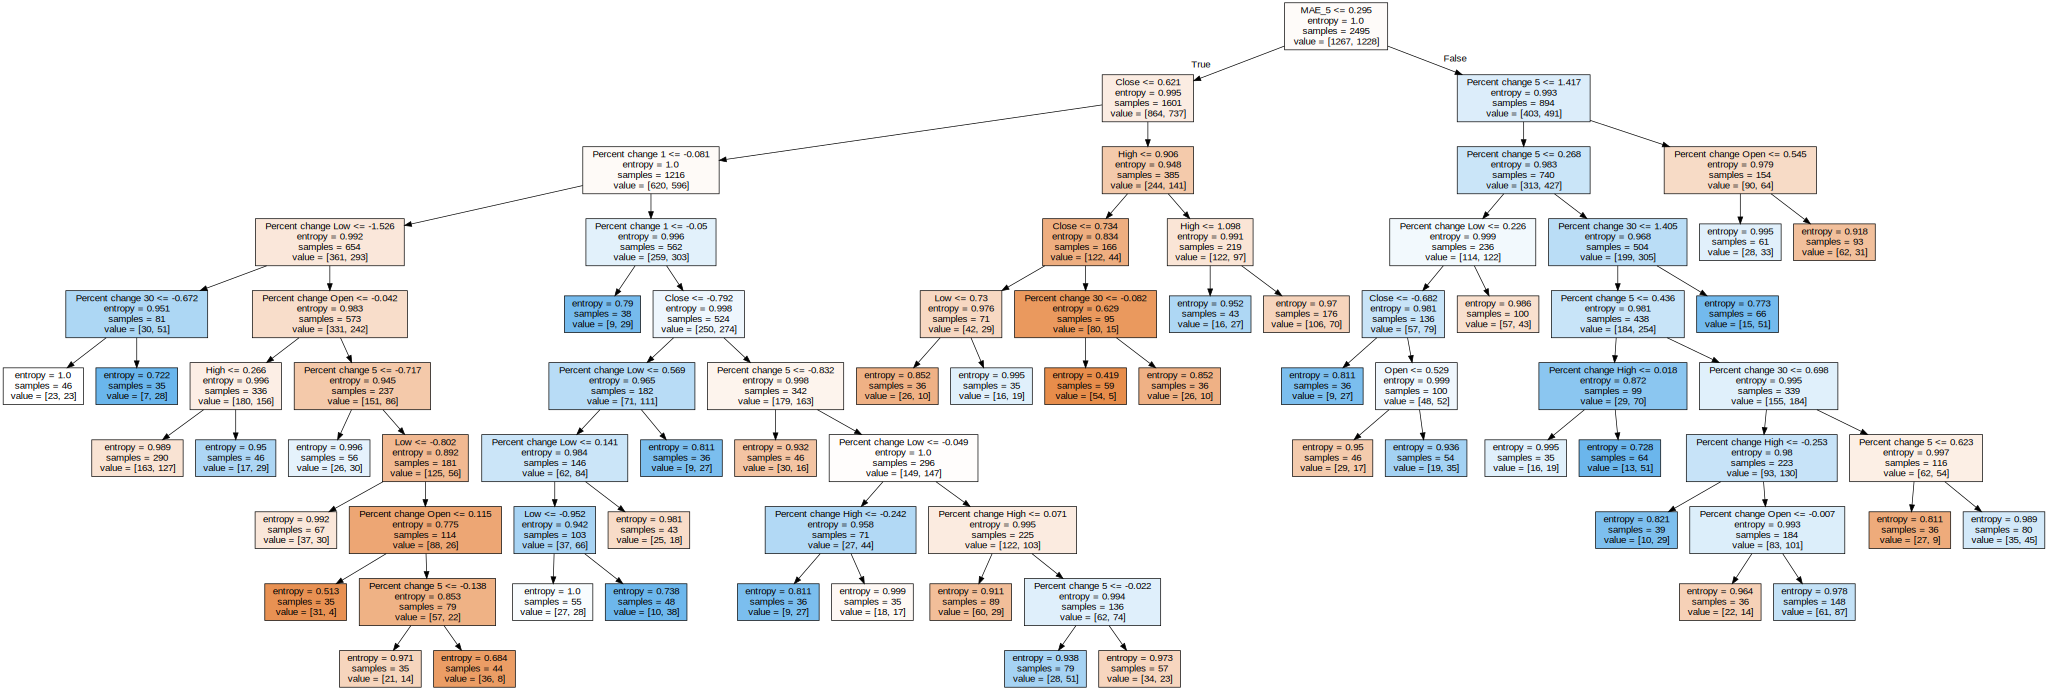

In [209]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=X_train_transformed.columns,filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

In [212]:
graph.render(filename='g1.dot')

'g1.dot.png'

In [213]:
dt = pd.DataFrame(y_predicted_test)

In [214]:
dt

,0
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
632,1.0
633,1.0
634,0.0
635,1.0


In [215]:
df_results = X_valid[['Close', 'Open']].copy()
df_results['DT'] = dt[0].values
df_results

,Close,Open,DT
Date,,,
2019-07-29,1614.96,1587.52,0.0
2019-07-30,1603.24,1614.96,0.0
2019-07-31,1601.91,1603.24,1.0
2019-08-01,1601.91,1601.91,0.0
2019-08-02,1583.93,1601.91,0.0
...,...,...,...
2022-02-17,1785.48,1717.35,1.0
2022-02-18,1774.84,1785.48,1.0
2022-02-21,1766.02,1774.84,0.0


In [216]:
results = trading_results(df_results["Close"], df_results["DT"])

for i in range(len(results)):
    if results[i] != 'n/a':
        results[i] = results[i]*100
        
amount = []
amount_ = 100
for element in results:
    if element != 'n/a':
        amount_ = amount_*(1+element/100)
        amount.append(amount_)
    else:
        amount.append(element)
amount[0] = 100

for i in range(len(amount)):
  if amount[i] != 'n/a':
      remember = amount[i]
  else:
      amount[i] = remember 

df_results["Results DT"] = amount
df_results

,Close,Open,DT,Results DT
Date,,,,
2019-07-29,1614.96,1587.52,0.0,100.000000
2019-07-30,1603.24,1614.96,0.0,100.000000
2019-07-31,1601.91,1603.24,1.0,100.408070
2019-08-01,1601.91,1601.91,0.0,100.006437
2019-08-02,1583.93,1601.91,0.0,100.006437
...,...,...,...,...
2022-02-17,1785.48,1717.35,1.0,34.244228
2022-02-18,1774.84,1785.48,1.0,34.244228
2022-02-21,1766.02,1774.84,0.0,33.734022


In [217]:
df_results.describe()

,Close,Open,DT,Results DT
count,637.000000,637.000000,637.000000,637.000000
mean,1601.987378,1601.774568,0.425432,66.426001
std,213.192445,213.154306,0.494797,21.546035
min,1248.000000,1248.000000,0.000000,32.794326
25%,1414.900000,1414.900000,0.000000,44.945630
50%,1573.790000,1573.790000,0.000000,70.828345
75%,1799.130000,1799.130000,1.000000,83.560309
max,2004.820000,2004.820000,1.000000,100.408070


In [219]:
df_results.to_excel('DT.xlsx')